The purpose of this notebook is to be a tutorial on how to use specufex grouping on redpy templates. 

This tutorial reads from an h5 file of redpy templates, and includes how to read .tgz files and save their information into an h5 file.

There is a 

---

Created by Nick Smoczyk 4/5/2023

Updated 4/17/2023

In [1]:
#imports and parameters
from specufex import BayesianNonparametricNMF, BayesianHMM #for nmf and hmm
import h5py #for reading h5 file
import numpy as np #for arrays and math
import pandas as pd #for dataframes
from obspy import Trace #for seeing waveforms
import matplotlib.pyplot as plt #for plots
from sklearn.cluster import KMeans #for grouping
import scipy.signal as sp #for calculating spectrograms
from tqdm import trange #for a progress meter

import eqcorrscan #for reading templates from .tgz
from eqcorrscan import Tribe #for reading templates from .tgz

Matched-filter CPU is not compiled! Should be here: /home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/fast_matched_filter/lib/matched_filter_CPU.so


### 1. Reading .tgz and saving as h5

In [2]:
homedir = '/home/smocz/expand_redpy_new_files/templates/' #directory to with .tgz file
filename = 'Volcano_Rainier_Network_UW_Station_RCM_Channel_HHZ.tgz' #name of .tgz file
savedir = '/home/smocz/expand_redpy_new_files/h5/' #directory to save h5 file in
h5name = '' #name of h5 file

In [19]:
T = Tribe().read(f'{homedir}{filename}') #read the .tgz file

#create data
wave_list = [] #list of arrays of stream data
name_list = [] #list of template names

for t in T[:20]: #for each of the first 20 templates in the tgz file
    t_id = t.name #template name
    waveform = t.st #tempalte stream
    wave_list.append(np.array(t.st[0].data)) #append stream data as an array
    name_list.append(t.name) #append names to list
#     break
    
wave_arr = np.array(wave_list)
print(wave_arr.shape) #should be (# of streams, length of streams) like (90, 3121) for 90 streams of length 3121

(20, 3121)


In [20]:
#add data to h5 file
with h5py.File("./specufex_data.h5", "w") as f:
    f.create_dataset("waveforms", data=wave_arr)
    f.create_dataset("template_name", data=name_list)

### 2. Reading h5 file

In [3]:
#load waveforms from h5 file
with h5py.File("./specufex_data.h5", "r") as f:
    waveforms = f["waveforms"][()]
    template_name = f["template_name"].asstr()[()]

print(f"{len(waveforms)} waveforms in file")

tdf = pd.DataFrame({"template_name":template_name,"waveform":list(waveforms)})
tdf.head()

20 waveforms in file


,template_name,waveform
0,rcmhhzrpra000,"[3.0627340694616154, 2.5487518161664533, 0.675..."
1,rcmhhzrpra001,"[-2.075366175415957, 2.531869744151012, 4.2914..."
2,rcmhhzrpra002,"[0.20577756183559548, -0.1754276222518661, -0...."
3,rcmhhzrpra003,"[-5.836989823604221, -2.879562960681237, 0.783..."
4,rcmhhzrpra004,"[-0.22583640882683498, 4.1090049945506975, 7.2..."


### 3. Spectrograms

In [4]:
#parameters

#stream filtering
fs = 40 #sampling rate
fqmin = 1 #minimum frequency for bandpass
fqmax = 10 #maximum frequency for bandpass

# spectrogram parameters
sgramMode='magnitude'
sgramScaling='spectrum'

# frequency/time resolution
nperseg = 64
noverlap = nperseg/4
nfft = 1024

#Kmeans
K = 6 # number of clusters to fit

#NMF
batches_nmf = 100000
batch_size = 1

#HMM
num_states = 8
batches_hmm = 5000

In [5]:
#calculate raw spectrograms with scipy
fSTFT, tSTFT, STFT_raw = sp.spectrogram(
    x=np.stack(tdf["waveform"].values),
    fs=fs,
    nperseg=nperseg,
    noverlap=noverlap,
    nfft=nfft,
    scaling=sgramScaling,
    axis=-1,
    mode=sgramMode
)

In [6]:
#quality check for NaN
np.isnan(STFT_raw).any()

False

In [7]:
#bandpass

freq_slice = np.where((fSTFT >= fqmin) & (fSTFT <= fqmax))
fSTFT   = fSTFT[freq_slice]
STFT_0 = STFT_raw[:,freq_slice,:].squeeze()

# STFT_0 = STFT_raw

In [8]:
#normalize spectrogram and make values nonnegative for nmf

normConstant = np.median(STFT_0, axis=(1,2))
STFT_norm = STFT_0 / normConstant[:,np.newaxis,np.newaxis]  # norm by median
del STFT_0
STFT_dB = 20*np.log10(STFT_norm, where=STFT_norm != 0) # convert to dB (database?)
del STFT_norm
STFT = np.maximum(0, STFT_dB) # make sure nonnegative
del STFT_dB

tdf["stft"] = list(STFT)
tdf.head()

,template_name,waveform,stft
0,rcmhhzrpra000,"[3.0627340694616154, 2.5487518161664533, 0.675...","[[0.0, 0.0, 0.0, 0.0, 1.015058808188686, 0.0, ..."
1,rcmhhzrpra001,"[-2.075366175415957, 2.531869744151012, 4.2914...","[[1.083578776118199, 4.915096646035321, 9.7218..."
2,rcmhhzrpra002,"[0.20577756183559548, -0.1754276222518661, -0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 6.462830087799749, ..."
3,rcmhhzrpra003,"[-5.836989823604221, -2.879562960681237, 0.783...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.412654..."
4,rcmhhzrpra004,"[-0.22583640882683498, 4.1090049945506975, 7.2...","[[7.9384904211590355, 0.0, 7.365669845320141, ..."


In [9]:
#quality check
bad_idx = tdf["stft"][tdf["stft"].apply(lambda x: np.isnan(x).any())].index
print(f"Bad spectrograms: \n{tdf.loc[bad_idx].template_name}")
tdf = tdf.drop(bad_idx).sort_values("template_name")

Bad spectrograms: 
Series([], Name: template_name, dtype: object)


/tmp/ipykernel_897133/4288673595.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(tSTFT,fSTFT,STFT_raw[n_spectrogram,freq_slice,:].squeeze())
/tmp/ipykernel_897133/4288673595.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(tSTFT,fSTFT, STFT[n_spectrogram])


Text(0.5, 1.0, 'Normalized spectrogram')

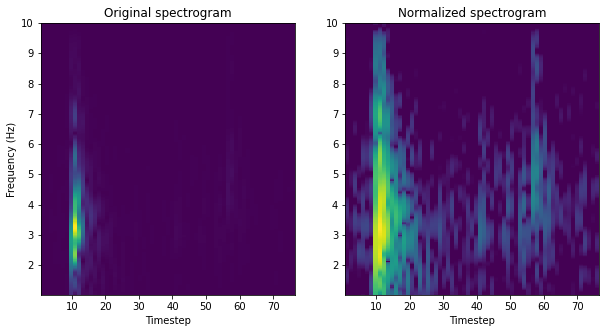

In [10]:
#plotting example spectrogram
n_spectrogram = 0 # index of spectrogram to plot

f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].pcolormesh(tSTFT,fSTFT,STFT_raw[n_spectrogram,freq_slice,:].squeeze())
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Frequency (Hz)")
ax[0].set_title("Original spectrogram")

ax[1].pcolormesh(tSTFT,fSTFT, STFT[n_spectrogram])
ax[1].set_xlabel("Timestep")
ax[1].set_title("Normalized spectrogram")

### 4. NMF

In [11]:
nmf = BayesianNonparametricNMF(np.stack(tdf["stft"].values).shape)

In [ ]:
t = trange(batches_nmf, desc="NMF fit progress ", leave=True)
for i in t:
    idx = np.random.randint(len(tdf["stft"].values), size=batch_size)
    nmf.fit(tdf["stft"].iloc[idx].values)
    t.set_postfix_str(f"Patterns: {nmf.num_pat}")

NMF fit progress :  77%|███████▋  | 77429/100000 [1:42:00<26:29, 14.20it/s, Patterns: 75]  

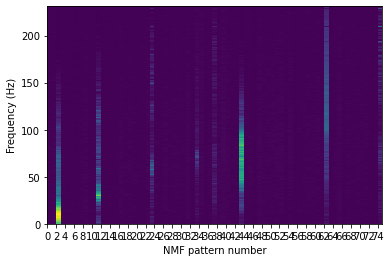

In [44]:
#plot
plt.pcolormesh(nmf.EW@np.diag(nmf.EA[0]))
plt.xlabel("NMF pattern number")
plt.xticks(range(0,nmf.num_pat,2), range(0,nmf.num_pat,2))
plt.ylabel("Frequency (Hz)")
plt.show()

In [45]:
print(type(nmf))

<class 'specufex.nmf.BayesianNonparametricNMF'>


In [21]:
#get activation matrix (Vs) from nmf
Vs = nmf.transform(tdf["stft"].values)

# save Vs to an hdf5
# with h5py.File("specu_data.h5", "w") as f: #saves Vs to h5 file (will overwrite file, so add any other datasets you want to still be saved)
    # f["Vs"] = Vs #Vs dataset
    # f["waveforms"] = waveforms #waveforms dataset
    # f["template_name"] = template_name #template names (waveform ID) dataset

specufex_Vs_data_full_tgz.h5


Text(0, 0.5, 'NMF pattern')

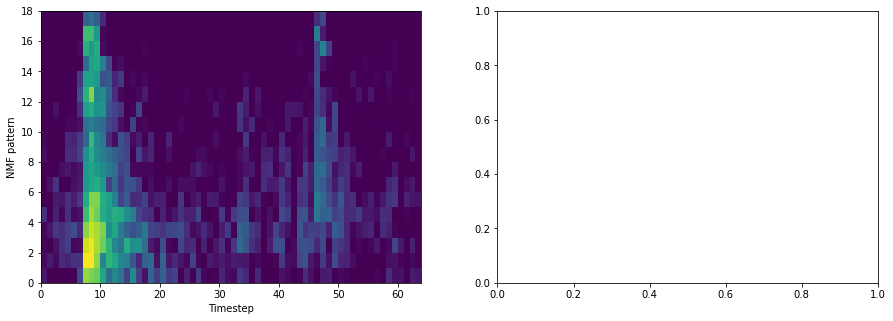

In [25]:
# for filename in ["specufex_data_.h5","specufex_data_selected_Vs_testing.h5","specufex_data_full_tgz_Vs_testing.h5"]:
filename = "specufex_Vs_data_full_tgz.h5"
with h5py.File(filename, "r") as f:
    Vs = f["Vs"][()]
print(filename)
f, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].pcolormesh(Vs[0])
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("NMF pattern")

### 5. HMM

In [26]:
hmm = BayesianHMM(nmf.num_pat, nmf.gain, num_state=num_states, Neff=50000)

NameError: name 'nmf' is not defined

In [24]:
t = trange(batches_hmm, desc="HMM fit progress ", leave=True)
for i in t:
    idx = np.random.randint(Vs.shape[0], size=1)
    hmm.fit(Vs[idx])

HMM fit progress : 100%|██████████| 5000/5000 [03:26<00:00, 24.25it/s]


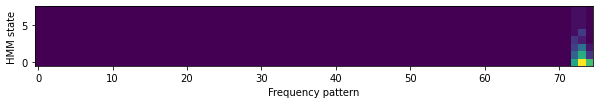

In [25]:
plt.figure(figsize=(10,5))
plt.imshow(hmm.EB, origin="lower")
plt.ylabel("HMM state")
plt.xlabel("Frequency pattern")
_=plt.yticks(range(0,num_states,5), range(0, num_states,5))

### 6. Fingerprint creation

In [ ]:
fingerprints, As, gams = hmm.transform(Vs) #create fingerprints
plt.imshow(fingerprints[0]) #show fingerprints

### 7. Kmeans Clustering

In [ ]:
# convert fingerprints from 2D array to 1D array
fingerprints_ = fingerprints.reshape((fingerprints.shape[0], fingerprints.shape[1]**2))

#Predicted labels
K=5 # number of clusters to fit, feel free to play around with it!
y_pred = KMeans(n_clusters=K, random_state=42).fit_predict(fingerprints_)
# y_pred #show y_pred, a np array of group/cluster IDs in same order as waveforms

tdf['Kmeans'] = list(y_pred) #save specufex group label to tdf
tdf.head() #show tdf

### 8. Show Kmeans results

In [ ]:
for x in np.unique(y_pred):
    print(f'group {x} has {list(y_pred).count(x)} waveforms') #print Kmeans group/cluster ID and number of waveforms in that group
    Trace(waveforms[list(y_pred).index(x)]).plot(); #plot the first stream in that cluster

In [ ]:
#show all waveforms in a group
kn = 1 #Kmeans group ID/number
print(f'===== PLOTS FOR KMEANS GROUP {kn} =====')

wave_list = tdf[tdf['Kmeans']==kn]['waveform'].values.tolist() #list of waveforms for a Kmeans group

for wave in wave_list:
  Trace(wave).plot();
  break